**Identify empty and similar images in the dataset**

The dataset has similar pictures in the dataset coming from the same biopsy sample. This notebook checks on those images so that they can be removed from the dataset. 

Alternatively, similar images with different tags could have been retained. Due to time limitations on the project only one sample from the similar images are kept in the dataset. This reduced the unrealistic high performance during training.

In [1]:
import tensorflow as tf
import pathlib,os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import skimage.io
from sklearn.model_selection import StratifiedKFold
import time
import albumentations
import tensorflow_addons as tfa
import tensorflow_hub as hub
from tensorflow.keras import layers,models

AUTOTUNE = tf.data.experimental.AUTOTUNE

import imagehash
import PIL

In [2]:
kaggle_data= '/data/users/rpravahan/panda'

data_dir=kaggle_data+'/train_images'
data_simple_dir='/home/emungan/panda/data_simple/images'
ds_dir = pathlib.Path(data_simple_dir)

label_dir=kaggle_data+'/train.csv'
train_labels = pd.read_csv(label_dir).set_index('image_id')

In [3]:
'''Helper Functions for reading, cropping white space and displaying images'''

def read_tiff(img_path,level):
    
    rgb      = skimage.io.MultiImage(str(img_path))[level]
    label    = img_path.split(os.sep)[-1].split('.')[0]
    
    return rgb,label
    
def crop_white(img, value: int = 255):
    
    img_arr=np.asarray(img)
    
    ys, = (img_arr.min((1, 2)) < value).nonzero()
    xs, = (img_arr.min(0).min(1) < value).nonzero()
    
    if len(xs) == 0 or len(ys) == 0:
        print(im_ID," is empty")
        return img_arr
   
    return  img_arr[ys.min():ys.max()+1, xs.min():xs.max()+1]         #return the cropped image

def show(im_ID,level):
    filepath=os.path.join(data_dir,im_ID+'.tiff')
    image,label= read_tiff(filepath,level)

    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')

In [4]:
'''Check for empty images'''
img_list= os.listdir(data_dir)

for file in img_list:
    im_ID=file.split('.')[0]
    filepath=os.path.join(data_dir,file)
    img,label= read_tiff(filepath,level=2)
    crop_white(img)
    print(filepath)
    break

/data/users/rpravahan/panda/train_images/be85e2b33823aeebfbd13873dc207ddc.tiff


In [5]:
"""Check problematic images"""
if(0):                                  
    im_ID='00d8a8c04886379e266406fdeff81c45'
    show(im_ID,level=1)

In [6]:
img_list= os.listdir(data_simple_dir)

if(0):                                  #get empty pics
    for file in img_list:
        if file.endswith('tiff'):
            im_ID=file.split('.')[0]
            filepath=os.path.join(data_dir,file)
            img,label= read_tiff(filepath,level=2)
            crop_white(img)
            print(filepath)


In [7]:
'''Hashing functions to be used for checking image similarity'''
funcs = [
    imagehash.average_hash,
    imagehash.phash,
    imagehash.dhash,
    imagehash.whash,
    #lambda x: imagehash.whash(x, mode='db4'),
]


hashes = []
tiff_list = []
for file in img_list:
    if file.endswith('.tiff'):
        tiff_list.append(file)
        im_ID=file.split('.')[0]
        filepath=os.path.join(data_dir,file)
        img,label= read_tiff(filepath,level=2)
            
        image= PIL.Image.fromarray(img)
        hashes.append(np.array([f(image).hash for f in funcs]).reshape(256))

**Let us see how the functions work for a small set of data**

In [8]:
print(np.array(hashes).shape)

(7, 256)


In [9]:
hashes = np.array(hashes).astype(int)
sims = np.array([(hashes[i] == hashes).sum(axis=1)/256 for i in range(hashes.shape[0])])
print (sims)

[[1.         0.6328125  0.55859375 0.65625    0.6015625  0.55859375
  0.62890625]
 [0.6328125  1.         0.62109375 0.6328125  0.6171875  0.54296875
  0.62109375]
 [0.55859375 0.62109375 1.         0.53515625 0.45703125 0.6015625
  0.59375   ]
 [0.65625    0.6328125  0.53515625 1.         0.5234375  0.62890625
  0.58203125]
 [0.6015625  0.6171875  0.45703125 0.5234375  1.         0.50390625
  0.64453125]
 [0.55859375 0.54296875 0.6015625  0.62890625 0.50390625 1.
  0.5703125 ]
 [0.62890625 0.62109375 0.59375    0.58203125 0.64453125 0.5703125
  1.        ]]


In [10]:
threshold = 0.63
duplicates = np.where(sims > threshold)
print(duplicates)

(array([0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 4, 4, 5, 6, 6]), array([0, 1, 3, 0, 1, 3, 2, 0, 1, 3, 4, 6, 5, 4, 6]))


In [11]:
hash_table=[]

for i,j in zip(*duplicates):
    if i > j:                 # get right upper matrix

        path1 = os.path.join(data_dir,tiff_list[i])
        path2 = os.path.join(data_dir,tiff_list[j])
    

path1 007433133235efc27a39f11df6940829.tiff
path2 005e66f06bce9c2e49142536caf2f6ee.tiff 

path1 001c62abd11fa4b57bf7a6c603a11bb9.tiff
path2 005e66f06bce9c2e49142536caf2f6ee.tiff 

path1 001c62abd11fa4b57bf7a6c603a11bb9.tiff
path2 007433133235efc27a39f11df6940829.tiff 

path1 004f6b3a66189b4e88b6a01ba19d7d31.tiff
path2 006f6aa35a78965c92fffd1fbd53a058.tiff 



**Now let us look at the full dataset for a threshold of 96% similarity**

In [20]:
"""Check for similar image pairs"""

img_list= os.listdir(data_dir)
threshold =0.96
        
funcs = [
    imagehash.average_hash,
    imagehash.phash,
    imagehash.dhash,
    imagehash.whash,
    #lambda x: imagehash.whash(x, mode='db4'),
]

hashes = []
tiff_list = []
for file in img_list:
    if file.endswith('.tiff'):
        im_ID=file.split('.')[0]
        tiff_list.append(im_ID)
        filepath=os.path.join(data_dir,file)
        img,label= read_tiff(filepath,level=2)         
        image= PIL.Image.fromarray(img)
        hashes.append(np.array([f(image).hash for f in funcs]).reshape(256))

hashes     = np.array(hashes).astype(int)
sims       = np.array([(hashes[i] == hashes).sum(axis=1)/256 for i in range(hashes.shape[0])])
duplicates = np.where(sims > threshold)


In [24]:
"""Combine several pictures that are similar"""

hash_table=[]

for i,j in zip(*duplicates):
    if i > j:                 # get right upper matrix
        s=set([tiff_list[i],tiff_list[j]])
        #print(s, hash_table)
        if(hash_table==[]):
            hash_table.append(s)
        else:
            belongs=0
            for i in range(len(hash_table)):
                if(not hash_table[i].isdisjoint(s)):
                    print('s intersects with ',hash_table[i])
                    hash_table[i]=hash_table[i].union(s)
                    belongs=1
            if not belongs:
                hash_table.append(s)
        

print(len(hash_table))

s intersects with  {'9effeea56c413b92340b89d1240769c1', 'b5343f9567df8a68c3276f8d8cdcc6a5'}
s intersects with  {'9effeea56c413b92340b89d1240769c1', 'b5343f9567df8a68c3276f8d8cdcc6a5', '367f122e80bcd0bffc02f6a04c1d8234'}
s intersects with  {'1438f19e07c389b47fd5219ca62f9f0a', '8982520da76f908b20b9f66c07ccc1e5'}
58


['6f310463d3868e86be87adddeccdde19', '0bd0dd2e0b715471eab534e1d815ebb2']


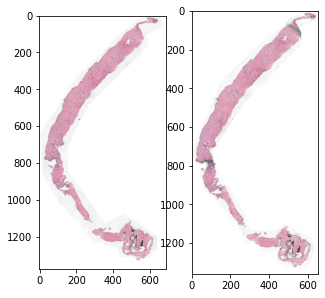

['6ef357192c2530ee54e1bd38a3231e00', '6890c90884c340a88a661384550e6339']


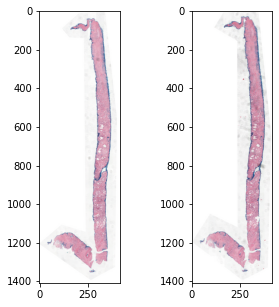

['511a33b7aeb1153407ed2d55cae001c8', 'f1a748bf771215ce5a166846e8d9af79']


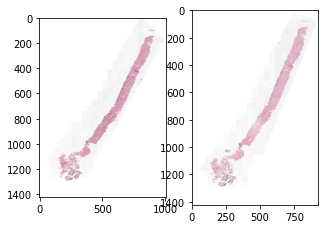

['2fb68d6713a52e322692dbc99ac82444', '3795ba90ba4303d37accaa4eaf82c747']


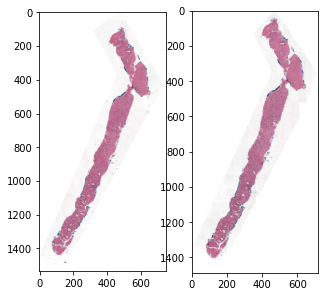

['8a415b0e974861fa00ae9d88f9e3b980', 'e2726cffee3499287c6f87b561dd228d']


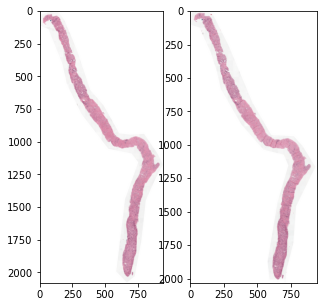

['eda92317b583435a810cac1dc7bb8025', '7641921e308edd4de40ad5f83db43a04']


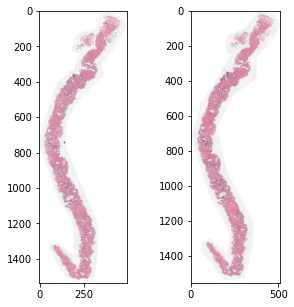

['c9dbdd9c9fc0eab0d235499488b26c53', 'fa6f7b3a6e9c17919d127c670423774e']


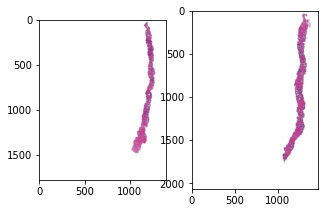

['99d9afb22b65ea97fcd21ce67e1ddb6c', 'aadc8c10f196efb7e460e0c424aec805']


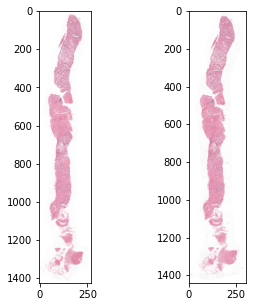

['0c46c60ae2ef49657bc843707162ba6e', '82f647e446251f53f15f8ccfe86608f8']


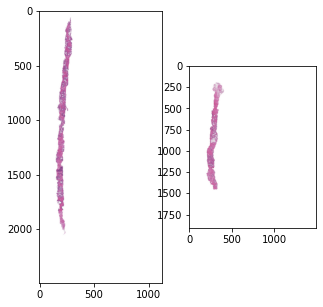

['85b7018a9e5287342a1392fb02ce24a1', 'ab106ca32e9155aa7e68eabef8e2ed59']


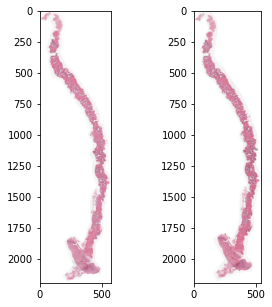

['4e80b5738f591c7d0d91889c2bdfd39d', '8013d514fff8374e2f0435f808a57d8e']


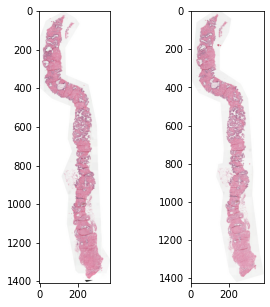

['f13cd8ec6e6fde523a0a065b62086d3c', '725f6e74ba6aed08098c779047a19559']


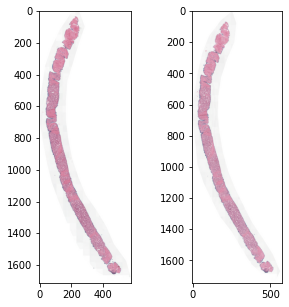

['aebe292567e0f8447fdc94994189a80a', '5a3e3dc26a1d2a473855a6161d870a96']


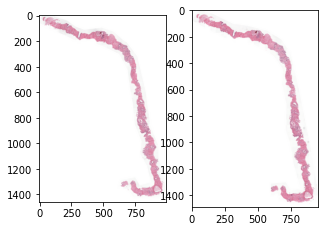

['6b512a45bd8ca759e655c2d551dec2d9', 'fc3c4b863c8e9defaf8f430cdee91183']


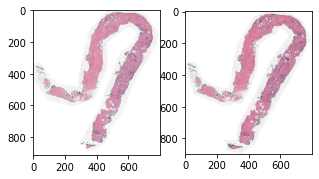

['be403ce415609008605d63396869ed2e', 'b0e4ac380ceb1b245dd4fe6052913919']


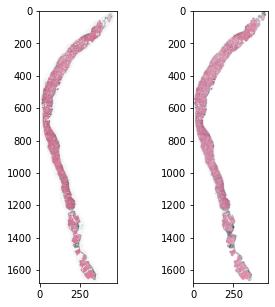

['e3360926180928287a4d96973e10926a', 'dc4bad3ab7879ce3549eb811c8e9fc1c']


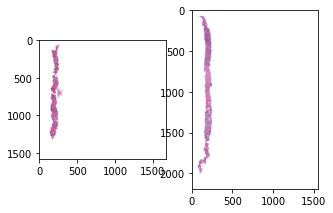

['3752b697cae9f81a9d5ffe44dac58e7a', '3b89fac978a021d49806d2f75cc9f4c2']


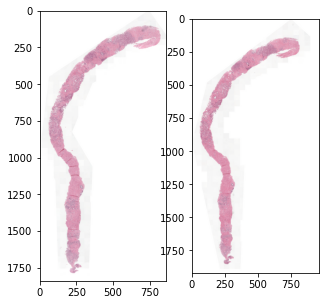

['a0ac3589042f9e99d31b521b5b56ac06', 'a4400c5e31462e7d221bb1a06d2ba0de']


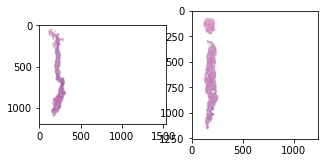

['f5675cb89a120e225ca8929b64a5af79', '3602a55ad5d1bc6c6cd903538b5b5abe']


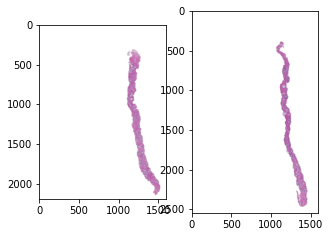

['6d569809f11e6e53918dfb1609fb0d83', '971e50ef7265bc3751d7cc7ff36a6f5b']


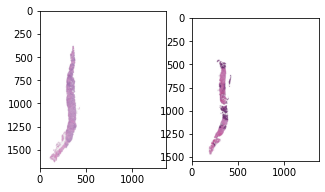

['7817ae2d392ba4f6cb9104fbe70b6274', '7f57053f651025603c6b4246acd0ba54']


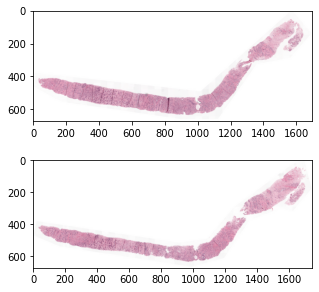

['cd382fdc26516c634b2314aa870bfe80', '2929fb804a8ce7c6e2210e0e5710c243']


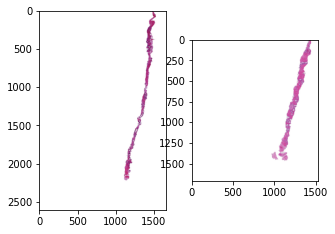

['1cdd6def1e3099a9763938457cf0b4be', 'f480b897adfe65f572f79d9f8d45ac9e']


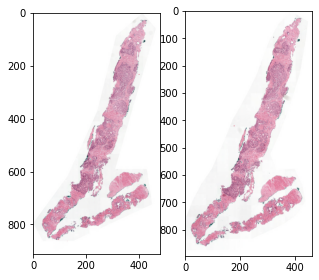

['0186f4811c9d089707d9dc7460160d88', 'fec79645cf3b92343f453b945916af29']


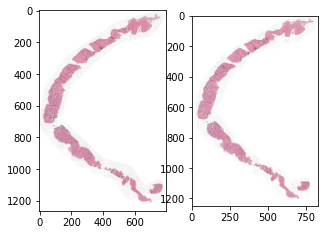

['e9d628364cf51891028163e0cfca628c', '9d1bda4d28af5a9f5d1d96833cec1728']


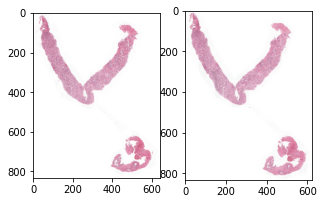

['9effeea56c413b92340b89d1240769c1', '367f122e80bcd0bffc02f6a04c1d8234', 'b5343f9567df8a68c3276f8d8cdcc6a5']


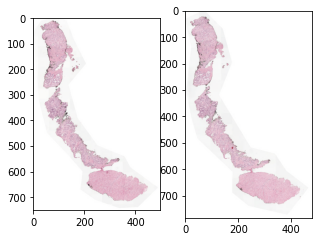

['7a0a36bc6119e3d78474e6c8ca875725', 'ea954ce0f1563b69d79bd1c2b7129618']


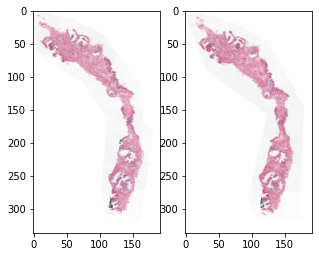

['374d5401159d9bf39ce20b395d82c0b4', '86fad088e10612415bb805aa7d53e387']


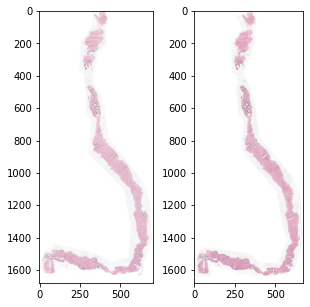

['7fa4634ab59a7832bc877fef162eacaa', 'a48b27a0f0f78595b8d71a4b373acf81']


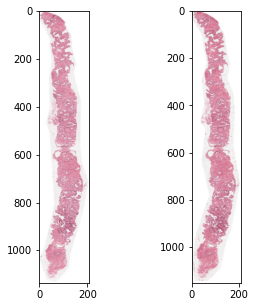

['ee182a14e532b122f40d561d87eb2136', '7b3f3b2a473fa265132ca41c139372b0']


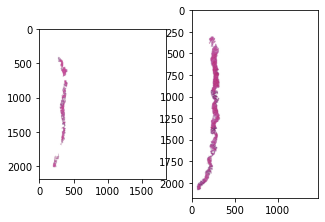

['c0a0956a39319920d02c5c4eb30c5e10', '1b86a85640e5832e6b27d89c8f99adf9']


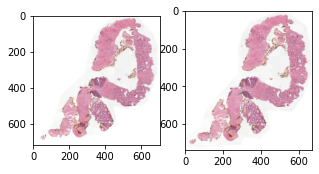

['441265c6b4598e9bcd10bc10eb6293cc', '7a1b601b146af835cef2bc71ea599c65']


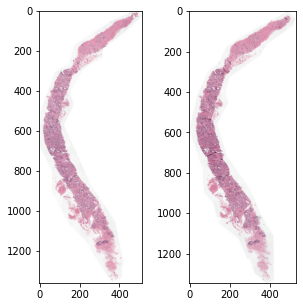

['8ae069858aecbad846f4d69d405f9bd6', 'a5dbc558ca9c9612b608645238c15129']


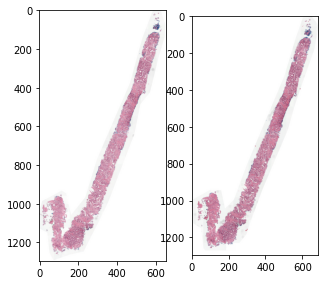

['b13961504ea859ff34a150bc19fed335', 'b95035c00e6e99f3b4e3cd210700f6ce']


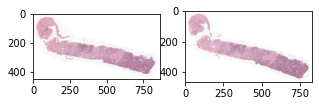

['476f0dfb144aee7d5422dcc3b2b97a9f', 'e187fc91f755db1d0885f19a0b333523']


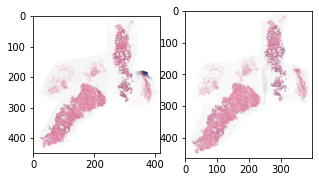

['bc93d165d96e4fa4883f130b3f7b9885', 'f5d40a40e34f8a090f44cb6589c26900']


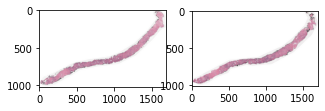

['ac9d05fa3f4fafb474fb96f9f8ab71ac', '874be9a5b3a7fc7127d02977c1f8a0c8']


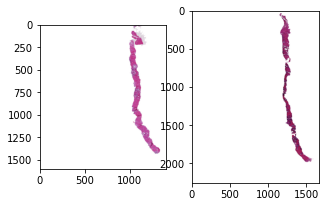

['1438f19e07c389b47fd5219ca62f9f0a', '9dbc64b9e7a18cfdd825ea44219b8330', '8982520da76f908b20b9f66c07ccc1e5']


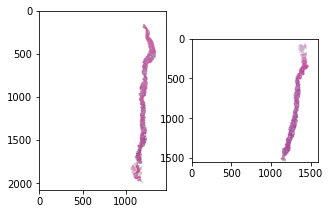

['479200a381febadfd767615fbe77c3ea', '9732d77870c47958a27d32126266ef89']


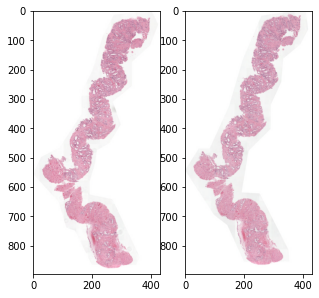

['fc6a695ba44f4b64425c522f590bac48', '8520e95c49091fe5676146fcedfb3793']


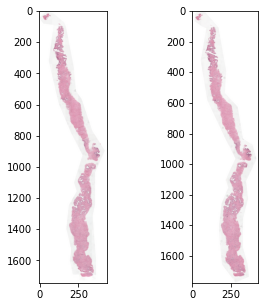

['046bac77a58c1be84a6418904e755280', '66ac9acd0174425c2ad47448fc55ca45']


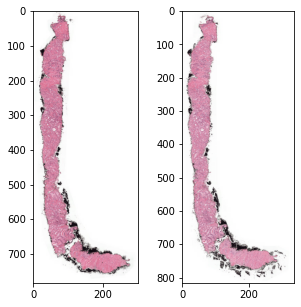

['5c083ab21fc57c0954468ab46aa7fb16', '9793c3c2317f38143d21a5187bb35652']


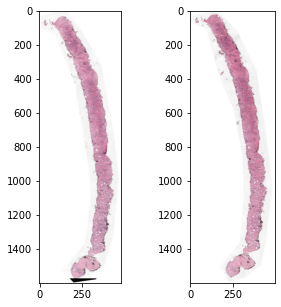

['cca735c397880e88192e97d68b97754e', '4abf4f8b4b7768af6eb06d3ef31b1e09']


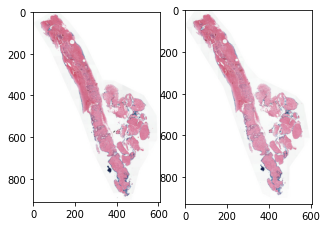

['a579110fe1e670847d9d146404597750', '291b2132e1fb9131478b8d691406874b']


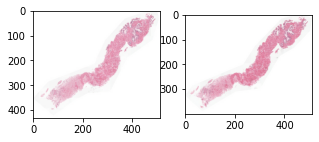

['8dbedd97ed2b7b01525d6800d52ae073', '35b2e442142f53c58e83e1a0f0636472']


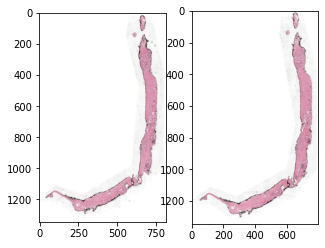

['004dd32d9cd167d9cc31c13b704498af', 'bd5aa0e284c6dc0b0b09513731f252a8']


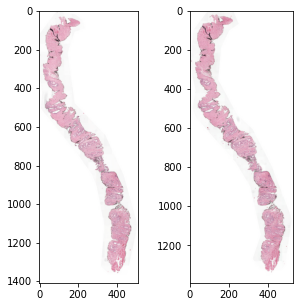

['cdf40333dfe2afec1a4c54d9eeb1ec7a', 'bfcc9e5ac8e39cf903c5a70ca5f8e2e7']


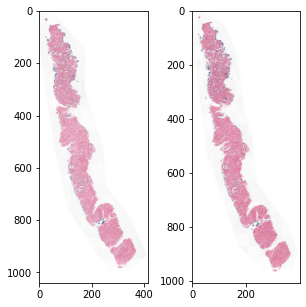

['09d4be69a2330cd49298bf30d29cc4e5', '2b1ea815af8da3697c64c682855f9b3b']


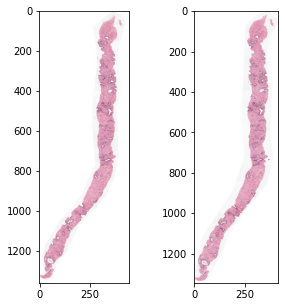

['f73951fddf77034c9fd44cb19f5fe6b5', '389758c9e3aad00e774d581150f372db']


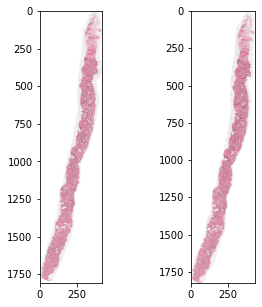

['aef75d4c390d838aabe56e2d601b6a13', '0a97bd73cd153b33751d43821ff0a400']


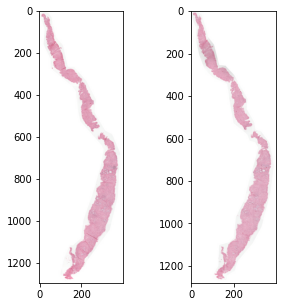

['b3a2dc7547bc580c6f3923c61db42051', 'f7b41d0ca05e2d1de4fd4b3fd0ae4ef7']


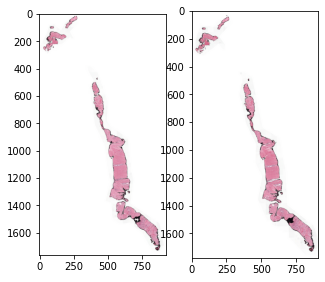

['774c9b631a29f191836b1078a6c3a67c', 'bdeb7ab6c22749f3a39e5a88ee4a0fa4']


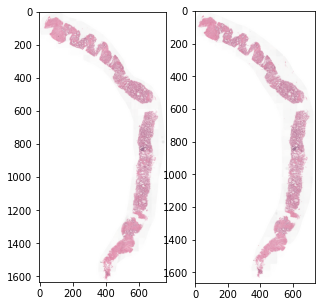

['836ca5d73c88ad94fb980ca3e5e65da7', 'b06b4755a9bbdb1e304f98a5d71e3c29']


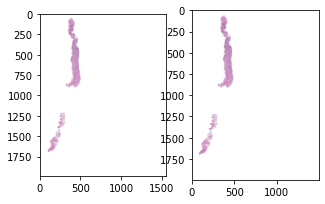

['bfdbe56fb7fc4d7b3d151370f897d503', 'cdefc4649194000c27f3fa17f936d517']


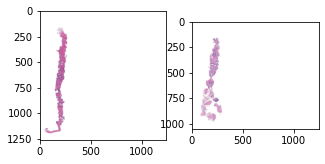

['06ef49a7b77e883f089cfdd80642d6f0', '687caedb62d68fd4692af68d695efc1c']


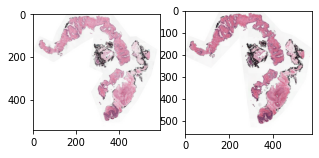

['8e25584bd03155d24a2adc00517a38e8', '0aa6472328e4807ba54a807b8332da0f']


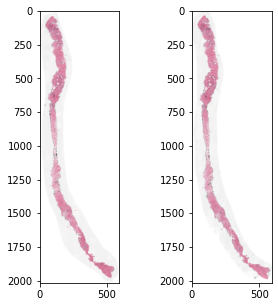

['dc2ec851fcbf594f11b023387ac15003', '303090fcc31ecc2584e6addeadfa1402']


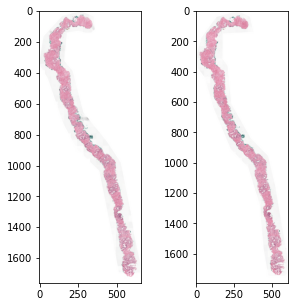

['a0150f4d6d9f6f3b2b5a240b099df000', '06bf945aaacb9a67d9f2439d9a7d73ea']


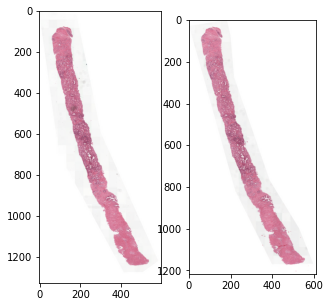

In [36]:
"""Display similar Images"""

for pairs in hash_table:
    lp= list(pairs)
    image1,label1= read_tiff(os.path.join(data_dir,lp[0]+'.tiff'),level=2)
    image2,label2= read_tiff(os.path.join(data_dir,lp[1]+'.tiff'),level=2)

    print(lp)
    if image1.shape[0] > image1.shape[1] / 2:
        fig,ax = plt.subplots(figsize=(5,5), ncols=2)
    elif image1.shape[1] > image1.shape[0] / 2:
        fig,ax = plt.subplots(figsize=(5,5), nrows=2)
    else:
        fig,ax = plt.subplots(figsize=(5,7), nrows=2)
    ax[0].imshow(image1)
    ax[1].imshow(image2)
    plt.show()



In [33]:
dummy=[]
for pairs in hash_table:
    dummy.append(list(pairs)[0])

print(dummy)
print(len(dummy))


['6f310463d3868e86be87adddeccdde19', '6ef357192c2530ee54e1bd38a3231e00', '511a33b7aeb1153407ed2d55cae001c8', '2fb68d6713a52e322692dbc99ac82444', '8a415b0e974861fa00ae9d88f9e3b980', 'eda92317b583435a810cac1dc7bb8025', 'c9dbdd9c9fc0eab0d235499488b26c53', '99d9afb22b65ea97fcd21ce67e1ddb6c', '0c46c60ae2ef49657bc843707162ba6e', '85b7018a9e5287342a1392fb02ce24a1', '4e80b5738f591c7d0d91889c2bdfd39d', 'f13cd8ec6e6fde523a0a065b62086d3c', 'aebe292567e0f8447fdc94994189a80a', '6b512a45bd8ca759e655c2d551dec2d9', 'be403ce415609008605d63396869ed2e', 'e3360926180928287a4d96973e10926a', '3752b697cae9f81a9d5ffe44dac58e7a', 'a0ac3589042f9e99d31b521b5b56ac06', 'f5675cb89a120e225ca8929b64a5af79', '6d569809f11e6e53918dfb1609fb0d83', '7817ae2d392ba4f6cb9104fbe70b6274', 'cd382fdc26516c634b2314aa870bfe80', '1cdd6def1e3099a9763938457cf0b4be', '0186f4811c9d089707d9dc7460160d88', 'e9d628364cf51891028163e0cfca628c', '9effeea56c413b92340b89d1240769c1', '7a0a36bc6119e3d78474e6c8ca875725', '374d5401159d9bf39ce20b395d